In [1]:
import numpy as np
import scipy.optimize as opt
np.set_printoptions(suppress=True)
from utils import *

In [2]:

def constant_sum(p: np.array):
    p = np.array(p)
    def f(x: np.array):
        x = np.array(x)
        # print("HERE")
        # print(x)
        return p @ x
    
    def f_grad(x: np.array):
        x = np.array(x)
        return p
    
    return f, f_grad

def constant_geo_mean():
    def f(x: np.array):
        x = np.array(x)
        return np.prod(x) ** (1 / len(x))
    
    def f_grad(x: np.array):
        x = np.array(x)
        return f(x) / (x * len(x))
    
    return f, f_grad

def stableswap(p: np.array, X: float):
    p = np.array(p)
    def f(x: np.array):
        x = np.array(x)
        return np.prod(x) ** (1 / len(x)) + X * np.sum(p * x)
    
    def f_grad(x: np.array):
        x = np.array(x)
        return (np.prod(x) ** (1 / len(x))) / (x * len(x)) + X * p
    
    return f, f_grad

AMMs = [
    # # constant_sum([1, 5]),
    # constant_sum([1, 2]),
    stableswap([1, 2], 0.5),
    constant_geo_mean(),
    constant_geo_mean(),
    constant_geo_mean()
]

N = len(AMMs)
K = 2

AMM_funs, AMM_grads = zip(*AMMs)

constraints = []

Delta = np.zeros((N, K))
initial_quantities = np.array([
    [10, 10],
    [10, 5],
    [10, 20],
    [20, 15],
    # [10, 25, 100]
])

# initial prices, normalized
initial_prices = np.array([
    grad(q) / np.sum(grad(q)) 
    for q, grad 
    in zip(initial_quantities, AMM_grads)])

# initial values of trading functions
orig_ks = np.array([f(q) for f, q in zip(AMM_funs, initial_quantities)])
# amount to scale profit, in terms of increase in trading function
multipliers = np.sum(initial_prices * initial_quantities, axis=1)


# # trading function must increase (don't need this bc they increase due to objective)
# def objective_satisfied(d, f, i):
#     d = np.reshape(d, (N, K))
#     return f(initial_quantities[i] + d[i]) - f(initial_quantities[i])

# for i, f in enumerate(AMM_funs):
#     constraints.append({
#         'type': 'ineq',
#         'fun': lambda d, f=f, i=i: objective_satisfied(d, f, i)
#     })

# reserves must be nonnegative
def nonnegative(d):
    d = np.reshape(d, (N, K))
    val = initial_quantities + d
    return np.min(val)


constraints.append({
    'type': 'ineq',
    'fun': lambda d: nonnegative(d)
})

# preserve network flow (each asset has non-positive sum)
# this is an inequality instead of equality to preserve convexity
def sums_to_zero(d):
    d = np.reshape(d, (N, K))
    return -np.sum(d, axis=0)
constraints.append({
    'type': 'ineq',
    'fun': lambda d: sums_to_zero(d)
})

# profit = proportional change in k times multiplier
def profits(d):
    new_quantities = initial_quantities + d
    new_ks = np.array([f(q) for f, q in zip(AMM_funs, new_quantities)])
    profit_per_amm = multipliers * (new_ks / orig_ks - 1)
    return profit_per_amm

for i in range(1, N):
    constraints.append({
        'type': 'ineq',
        'fun': lambda d, i=i: profits(d.reshape((N, K)))[i] - profits(d.reshape((N, K)))[0]
    })


def objective(d):
    d = np.reshape(d, (N, K))
    # only optimize for the first AMM since the others are constrained to move with it
    return -profits(d)[0]
    # return -np.sum(profits(d))

res = opt.minimize(objective, Delta.flatten(), constraints=constraints)

d = res.x.reshape((N, K))
new_q = initial_quantities + d
new_ks = np.array([amm_f(q) for amm_f, q in zip(AMM_funs, new_q)])
new_ks / orig_ks
print(f"original prices: \n{initial_prices}")
print(f"multipliers: \n{multipliers}")
print(f"original quantities: \n{initial_quantities}")
print(f"new quantities: \n{new_q}")
print(f"delta: \n{d}")
print(f"change in k: \n{new_ks / orig_ks}")
prices = np.array([grad(q) / np.sum(grad(q)) for q, grad in zip(new_q, AMM_grads)])
print(f"new prices: \n{prices}")
print(f"profits: \n{profits(d)}")
print(res)



original prices: 
[[0.4        0.6       ]
 [0.33333333 0.66666667]
 [0.66666667 0.33333333]
 [0.42857143 0.57142857]]
multipliers: 
[10.          6.66666667 13.33333333 17.14285714]
original quantities: 
[[10 10]
 [10  5]
 [10 20]
 [20 15]]
new quantities: 
[[ 7.0429233  12.98589677]
 [ 8.10698416  6.98545134]
 [15.72463555 13.54915417]
 [19.12545699 16.47949772]]
delta: 
[[-2.9570767   2.98589677]
 [-1.89301584  1.98545134]
 [ 5.72463555 -6.45084583]
 [-0.87454301  1.47949772]]
change in k: 
[1.04283045 1.06424568 1.03212284 1.02498443]
new prices: 
[[0.46284378 0.53715622]
 [0.46284454 0.53715546]
 [0.46284251 0.53715749]
 [0.46284282 0.53715718]]
profits: 
[0.42830453 0.42830453 0.42830453 0.42830452]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.4283045267053631
       x: [-2.957e+00  2.986e+00 -1.893e+00  1.985e+00  5.725e+00
           -6.451e+00 -8.745e-01  1.479e+00]
     nit: 24
     jac: [-4.716e-01 -5.473e-01  0.000e+00  0.000e+00  0

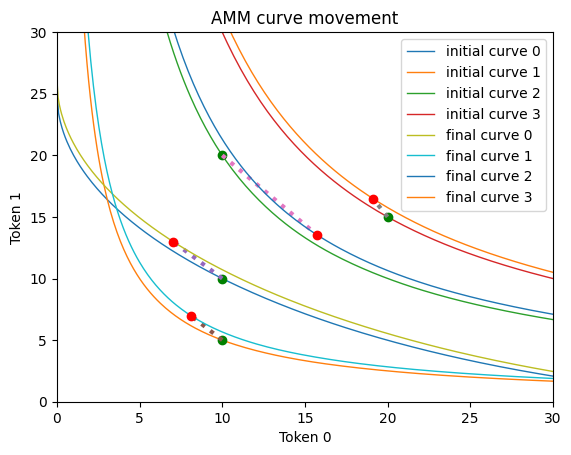

In [9]:
import matplotlib.pyplot as plt

bounds = Bounds(
    x_min = 0.0001,
    x_max = 30,
    y_min = 0.0001,
    y_max = 30,
)

for i, amm in enumerate(AMMs):
    plot_2d(amm, initial_quantities[i], 0, 1, bounds, n=100, label=f"initial curve {i}", color='green')


plt.title("Initial AMM curves")
# plt.show()

for i, amm in enumerate(AMMs):
    # draw line from initial quantities to final quantities
    plt.plot([initial_quantities[i][0], new_q[i][0]], [initial_quantities[i][1], new_q[i][1]], lw=3, ls=':')

plt.title("AMM curve movement")

for i, amm in enumerate(AMMs):
    plot_2d(amm, new_q[i], 0, 1, bounds, n=100, label=f"final curve {i}")

In [4]:
initial_quantities[1]

array([10,  5])

In [5]:
new_q[0]

array([ 7.0429233 , 12.98589677])